# About

Here we prepare, plot (and save) the results for CI plots, which were obtained in:
- `colab_extended_ci_rf_and_gp_saving_results.ipnb`

The notebook includes both one-run and multiple-runs CIs plots

In [1]:
%ls

all_plots.ipynb
colab_extended_GPflow_pipeline.ipynb
colab_extended_ci_rf_and_gp_saving_results.ipynb
colab_extended_grid_search_pipeline.ipynb
colab_reproducing_ci_gp.ipynb
colab_reproducing_ci_rf.ipynb
colab_reproducing_grid_search_pipeline.ipynb
eda.ipynb
prepare_and_plot_extended_ci_rf_and_gp_results.ipynb
prepare_extended_grid_search_results.ipynb
prepare_reproducing_grid_search_results.ipynb


In [2]:
%ls ../data/

ESOL_README
FreeSolv_README
Lipo_README
esol_original.csv
esol_original_1024ecfp4_features.csv
esol_original_1024ecfp6_features.csv
esol_original_2048ecfp4_features.csv
esol_original_2048ecfp6_features.csv
esol_original_IdSmilesLabels.csv
esol_original_extra_features.csv
esol_original_rdkit_features.csv
freesolv_original.csv
freesolv_original_1024ecfp4_features.csv
freesolv_original_1024ecfp6_features.csv
freesolv_original_2048ecfp4_features.csv
freesolv_original_2048ecfp6_features.csv
freesolv_original_IdSmilesLabels.csv
freesolv_original_rdkit_features.csv
lipophilicity_original.csv
lipophilicity_original_1024ecfp4_features.csv
lipophilicity_original_1024ecfp6_features.csv
lipophilicity_original_2048ecfp4_features.csv
lipophilicity_original_2048ecfp6_features.csv
lipophilicity_original_IdSmilesLabels.csv
lipophilicity_original_rdkit_features.csv


## Import modules

### Standard imports

In [3]:
import json
import pickle

import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# metrics
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import jaccard_score # Tanimoto

### Custom imports

In [5]:
sys.path.insert(0, '..')

# plotting
from util_scripts.plotting_functions_and_vars import FIGSIZE_CI, FIGSIZE_HEATMAP, DPI, PLOTS_DIR
from util_scripts.plotting_functions_and_vars import datasets_to_titles, datasets_to_units, metrics_to_labels
from util_scripts.plotting_functions_and_vars import plot_algorithm_dataset_comparison_heatmap


from util_scripts.plotting_functions_and_vars import datasets_to_rounding_precision

sys.path.insert(0, './notebooks')

## Set plotting style

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# sns.set()

# Load Data

## CHOOSE: dataset, smile_type, grid_search_type

In [7]:
dataset = 'lipophilicity'
assert dataset in ['freesolv', 'esol', 'lipophilicity']

smile_type = 'original'
assert smile_type in ['original', 'protonated']

grid_search_type = 'extended'
assert grid_search_type in ['reproducing', 'extended']

# correlated features treatment
if dataset == 'esol':
    cf = 'reduced'
else:
    cf = 'full'
assert cf in ['reduced', 'full']

In [8]:
# # for esol
# cf = 'full'

## Titles, Units and Labels for datasets

In [9]:
for key, value in datasets_to_titles.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  Solvation Energy
esol          :  Log Solubility
lipophilicity :  Octanol/Water Distribution Coefficient


In [10]:
for key, value in datasets_to_units.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

freesolv      :  (kcal/mol)
esol          :  (mol/litre)
lipophilicity :  (logD)


In [11]:
for key, value in metrics_to_labels.items():
    print(key, (13 - len(key))*' ' + ': ',  value)

RMSE          :  root-mean-square error
MAE           :  mean absolute error
R^2           :  R^2 (coefficient of determination)
pearson_r     :  Pearson correlation


In [12]:
rp = datasets_to_rounding_precision[dataset]
rp

3

## CHOOSE metric to display

In [13]:
metric = 'RMSE'
assert metric in metrics_to_labels

In [14]:
if metric in ['RMSE', 'MAE']:
    pass
else:
    # no units
    datasets_to_units = {'freesolv': '', 'esol': '', 'lipophilicity': ''}

## Choose model to show

In [15]:
model = 'rf'
assert model in ['rf', 'gp']

## Load files:

In [16]:
print(dataset, smile_type, grid_search_type, cf, model)

lipophilicity original extended full rf


In [17]:
# save results as csv-s, rewrite each time
df_true = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_true_{model}.csv')
df_pred = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_pred_{model}.csv')
df_std = pd.read_csv(f'../results/{dataset}_{smile_type}_{grid_search_type}_{cf}_multiple_ci_runs_std_{model}.csv')

## Have a look at files

In [18]:
df_true.shape, df_pred.shape, df_std.shape

((840, 30), (840, 30), (840, 30))

In [19]:
df_true.head()

,test_true_0,test_true_1,test_true_2,test_true_3,test_true_4,test_true_5,test_true_6,test_true_7,test_true_8,test_true_9,...,test_true_20,test_true_21,test_true_22,test_true_23,test_true_24,test_true_25,test_true_26,test_true_27,test_true_28,test_true_29
0,2.63,1.71,3.30,-0.72,3.20,2.16,3.99,0.70,0.02,1.09,...,4.38,3.21,1.25,3.80,2.29,1.25,4.00,3.67,2.50,1.81
1,-0.91,1.90,1.26,0.75,4.24,2.12,4.20,2.60,2.66,1.92,...,2.93,2.37,3.20,2.91,0.91,3.30,0.30,2.38,0.70,3.14
2,3.21,2.10,2.34,2.71,1.81,0.98,1.57,3.80,1.91,1.00,...,3.55,1.50,3.40,4.20,-1.18,2.26,4.20,3.00,2.51,1.87
3,2.90,0.78,0.80,2.50,-0.71,2.02,0.68,1.69,2.95,3.54,...,0.90,0.22,-0.10,3.44,0.85,1.70,2.79,3.40,2.38,2.30
4,3.07,0.75,2.41,3.32,2.32,2.80,2.50,2.46,3.10,3.10,...,2.78,1.70,2.80,3.67,3.50,3.90,-0.27,0.96,0.15,1.20


In [20]:
df_pred.head()

,test_pred_0,test_pred_1,test_pred_2,test_pred_3,test_pred_4,test_pred_5,test_pred_6,test_pred_7,test_pred_8,test_pred_9,...,test_pred_20,test_pred_21,test_pred_22,test_pred_23,test_pred_24,test_pred_25,test_pred_26,test_pred_27,test_pred_28,test_pred_29
0,2.619470,1.482603,2.208232,0.189911,3.478523,0.937740,3.682811,1.099396,0.453467,1.359727,...,2.123894,3.130277,2.203353,2.099853,2.676526,2.161940,3.043485,3.408261,2.881986,1.451086
1,1.676191,2.515472,2.198547,1.588650,3.264839,2.664647,3.566324,2.629442,2.737457,1.990614,...,2.684032,2.410204,2.018032,1.938040,1.338877,2.602325,0.625622,2.095873,1.251972,3.116037
2,2.517569,1.674679,2.221512,2.355000,1.865242,2.707548,3.281862,2.630821,2.686316,1.612419,...,3.224825,0.927642,3.271603,3.188568,-0.369811,2.427282,1.574485,2.885289,2.433854,2.513016
3,2.723466,1.056000,1.264860,2.379331,0.006223,2.148772,1.088994,2.014088,3.028093,3.389239,...,1.256401,0.226770,1.016453,2.795768,0.452826,2.350984,2.155776,2.864887,2.872611,1.827681
4,1.901214,1.784129,2.555648,2.594397,2.303734,2.356811,2.309452,3.044621,2.925301,2.911028,...,2.956209,1.445853,2.378854,3.496361,3.229906,2.401105,0.176552,1.424581,0.993337,0.630053


In [21]:
df_std.head()

,test_std_0,test_std_1,test_std_2,test_std_3,test_std_4,test_std_5,test_std_6,test_std_7,test_std_8,test_std_9,...,test_std_20,test_std_21,test_std_22,test_std_23,test_std_24,test_std_25,test_std_26,test_std_27,test_std_28,test_std_29
0,0.537095,0.338517,0.435627,0.346405,0.455823,0.330770,0.364442,0.513534,0.544051,0.459483,...,0.491083,0.476398,0.423364,0.393592,0.463973,0.549963,0.454341,0.335004,0.478187,0.355805
1,0.527078,0.366311,0.473248,0.433435,0.475468,0.397148,0.390687,0.394809,0.531910,0.457895,...,0.522680,0.521246,0.374903,0.381334,0.457272,0.563421,0.307558,0.426169,0.511153,0.377904
2,0.549449,0.495256,0.396500,0.489832,0.510611,0.417577,0.340535,0.438870,0.496616,0.493974,...,0.473829,0.408953,0.356237,0.379843,0.377145,0.553121,0.515928,0.399625,0.521078,0.437393
3,0.519508,0.325156,0.412410,0.469114,0.432354,0.453281,0.403912,0.434884,0.470480,0.523401,...,0.457041,0.386441,0.279722,0.412551,0.391827,0.563237,0.467238,0.304716,0.527056,0.358123
4,0.567700,0.337610,0.401393,0.490290,0.520134,0.387105,0.410688,0.427894,0.491200,0.419965,...,0.482366,0.492389,0.385160,0.343416,0.353223,0.551361,0.359885,0.404836,0.489738,0.348959


# One run

In [22]:
y_test = df_true.iloc[:, 0]
y_test_pred = df_pred.iloc[:, 0]
y_test_std = df_std.iloc[:, 0]

## RMSE

In [23]:
mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)

0.6704405211767106

## Calculate confidence bounds using std part of gpr predictions

In [24]:
upper = y_test_pred + 1.96 * y_test_std
lower = y_test_pred - 1.96 * y_test_std

In [25]:
CIs_df = pd.DataFrame(
    {'y_test': y_test,
     'y_test_pred': y_test_pred,
     'y_test_std': y_test_std,
     'lower': lower,
     'upper': upper,
     'sq_error': (y_test - y_test_pred) ** 2
     }
)
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
display(CIs_df)

,y_test,y_test_pred,y_test_std,lower,upper,sq_error,cumul_sq_error,cumul_mse,cumul_rmse
22,-1.10,-0.419521,0.322499,-1.051620,0.212578,0.463052,0.463052,0.463052,0.680479
27,-0.15,-0.239007,0.332190,-0.890099,0.412085,0.007922,0.470974,0.235487,0.485270
316,-0.82,-0.387454,0.374432,-1.121341,0.346432,0.187096,0.658070,0.219357,0.468355
40,-1.20,-0.284922,0.399888,-1.068703,0.498859,0.837368,1.495438,0.373860,0.611441
674,-1.27,0.104566,0.406933,-0.693023,0.902155,1.889432,3.384870,0.676974,0.822784
...,...,...,...,...,...,...,...,...,...
271,2.40,2.138730,0.611823,0.939557,3.337902,0.068262,372.376890,0.445427,0.667403
488,0.01,1.598447,0.616082,0.390927,2.805968,2.523165,374.900055,0.447909,0.669260
51,1.80,1.587505,0.617483,0.377239,2.797772,0.045154,374.945209,0.447429,0.668901
236,0.64,1.966885,0.631663,0.728825,3.204946,1.760624,376.705833,0.448994,0.670070


In [26]:
# checking that calculating rmse each time separately would be the same
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)


calculation_match = []
for i in range(CIs_df.shape[0]):
    a = CIs_df.y_test[:i+1]
    b = CIs_df.y_test_pred[:i+1]
    
    calculation_match.append(np.abs(mean_squared_error(a, b, squared=False) - CIs_df.cumul_rmse.iloc[i]) < 1e-8)
    
# if returns true - it is the same
assert np.all(calculation_match) 

## Plot test observations with sdt values as colours

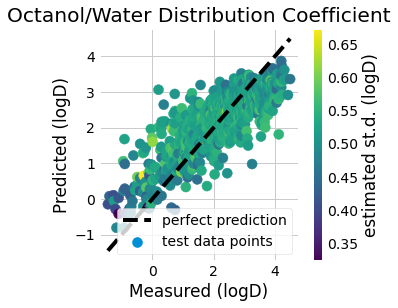

In [27]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test, y=CIs_df.y_test_pred, c=CIs_df.y_test_std, s=100, label='test data points')

plt.xlabel(f'Measured {datasets_to_units[dataset]}')
plt.ylabel(f'Predicted {datasets_to_units[dataset]}')
plt.title(f'{datasets_to_titles[dataset]}')

# add colourbar and legend
plt.colorbar(label=f'estimated st.d. {datasets_to_units[dataset]}')
plt.legend()

plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_scatter_colour_conf_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Plot sq^error vs std

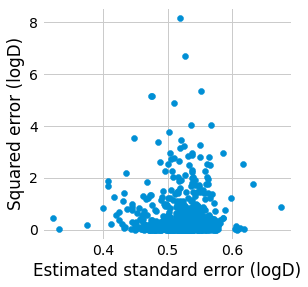

In [28]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std')

# Plot error bars for predicted quantity using unbiased variance
plt.figure(figsize=FIGSIZE_CI)

#plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')
plt.scatter(x=CIs_df.y_test_std, y=CIs_df.sq_error)


plt.xlabel(f'Estimated standard error {datasets_to_units[dataset]}')
plt.ylabel(f'Squared error {datasets_to_units[dataset]}')
# plt.title(f'{datasets_to_titles[dataset]}')

# # add colourbar and legend
# plt.colorbar()
# plt.legend()

#plt.savefig(f'{PLOTS_DIR}/pubs_units_values.png', bbox_inches='tight')
plt.show()

## Plot 95% confidence intervals

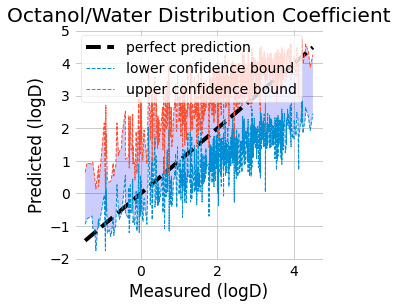

In [29]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test')

fig, ax = plt.subplots(1, figsize=FIGSIZE_CI)

# ax.set_aspect('equal')

ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'k--', label='perfect prediction')

ax.plot(CIs_df.y_test, CIs_df.lower, linewidth=1, linestyle='--', label='lower confidence bound')
ax.plot(CIs_df.y_test, CIs_df.upper, linewidth=1, linestyle='--', label='upper confidence bound')
ax.fill_between(CIs_df.y_test, CIs_df.upper, CIs_df.lower, facecolor='blue', alpha=0.2)




ax.set_title(f'{datasets_to_titles[dataset]}')
ax.set_xlabel(f'Measured {datasets_to_units[dataset]}')
ax.set_ylabel(f'Predicted {datasets_to_units[dataset]}')

ax.legend(loc='upper left')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/predicted_vs_measured_with_ci_bounds_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

## Calculate the proportion of measured values in test set within 95% CIs

In [30]:
within_cis = (CIs_df.lower <= CIs_df.y_test) & (CIs_df.y_test <= CIs_df.upper)
within_cis.sum() / len(within_cis)

0.8761904761904762

## Confidence plots (RMSE vs Prcentile)

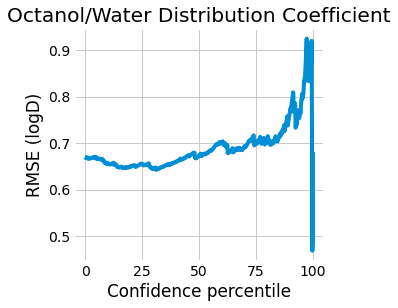

In [31]:
# sort values used for x axis
CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)

# set size
plt.figure(figsize=FIGSIZE_CI)

confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]


plt.plot(confidence_percentiles, flipped_cumul_rmse)
plt.title(datasets_to_titles[dataset])
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_one_run_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

In [32]:
corr, p_value = pearsonr(confidence_percentiles, flipped_cumul_rmse)
corr, p_value

(0.7326054013062566, 3.6896446690908566e-142)

# Multiple runs

In [33]:
dataset_to_num_cis = {
    'freesolv': 50,
    'esol': 30,
    'lipophilicity': 10
}

In [34]:
dataset_to_num_cis[dataset]

10

In [35]:
rmse_mult_runs = []
within_95_cis_mult_runs = []
cumulrmse_vs_percentile_corr_mult_runs = []

flipped_cumulrmse_mult_runs = []

for i in range(dataset_to_num_cis[dataset]):
    
    # get data
    y_test = df_true.iloc[:, i]
    y_test_pred = df_pred.iloc[:, i]
    y_test_std = df_std.iloc[:, i]
    
    # calculate and record rmse
    rmse_mult_runs.append(mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False))
    
    # calculate upper and lower 95% conf bounds
    upper = y_test_pred + 1.96 * y_test_std
    lower = y_test_pred - 1.96 * y_test_std
    
    # calculate and record proportion of true values within 95% CI from prediction
    within_cis = (lower <= y_test) & (y_test <= upper)
    within_cis_proportion = within_cis.sum() / len(within_cis)
    within_95_cis_mult_runs.append(within_cis_proportion)
    
    # create a dataframe to be able to sort things easily
    CIs_df = pd.DataFrame(
        {'y_test': y_test,
         'y_test_pred': y_test_pred,
         'y_test_std': y_test_std,
         'lower': lower,
         'upper': upper,
         'sq_error': (y_test - y_test_pred) ** 2
        }
    )
    
    # create cumulative rmse column
    CIs_df = CIs_df.sort_values(by='y_test_std', ascending=True)
    CIs_df['cumul_sq_error'] = CIs_df['sq_error'].cumsum()
    CIs_df['cumul_mse'] = CIs_df['cumul_sq_error'].values / np.arange(1, CIs_df.shape[0]+1)
    CIs_df['cumul_rmse'] = np.sqrt(CIs_df['cumul_mse'])
    
    # record confidence percentiles and flip cumulative rmses
    confidence_percentiles = np.arange(1e-14, 100, 100/len(y_test))
    flipped_cumul_rmse = CIs_df['cumul_rmse'].values[::-1]
    
    # record flipped cumulative rmse
    flipped_cumulrmse_mult_runs.append(flipped_cumul_rmse)
    
    # record correlation between cumulative rmse and confidence percentile
    cumulrmse_vs_percentile_corr_mult_runs.append(pearsonr(confidence_percentiles, flipped_cumul_rmse)[0])

print('Done')

Done


# Important metrics (corr, rmse, within_95)

In [36]:
dataset, cf, model

('lipophilicity', 'full', 'rf')

## Correlation

In [37]:
#cumulrmse_vs_percentile_corr_mult_runs

In [38]:
np.mean(cumulrmse_vs_percentile_corr_mult_runs).round(3), np.std(cumulrmse_vs_percentile_corr_mult_runs).round(3)

(0.268, 0.346)

## RMSE

In [39]:
#rmse_mult_runs

In [40]:
np.mean(rmse_mult_runs).round(3), np.std(rmse_mult_runs).round(3)

(0.671, 0.02)

## Within 95% CIs

In [41]:
#within_95_cis_mult_runs

In [42]:
np.mean(within_95_cis_mult_runs).round(3), np.std(within_95_cis_mult_runs).round(3)

(0.811, 0.042)

# Separate plots (do not save)

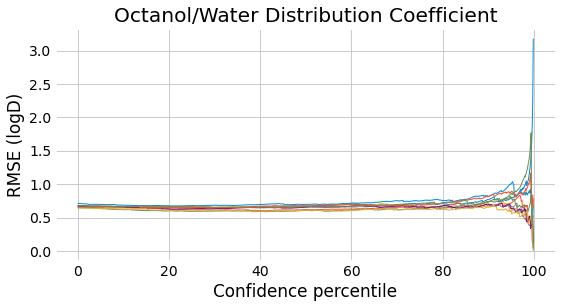

In [43]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    plt.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

plt.title(datasets_to_titles[dataset])
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')


#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_mult_run_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

# Calculations for Confidence Plot

In [44]:
#print(np.array(flipped_cumulrmse_mult_runs).shape)
#print(np.array(flipped_cumulrmse_mult_runs).std(axis=0).shape)
#print(np.array(flipped_cumulrmse_mult_runs).mean(axis=0).shape)

flipped_cumulrmse_mean = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)
flipped_cumulrmse_sdt = np.array(flipped_cumulrmse_mult_runs).mean(axis=0)

flipped_cumulrmse_lower = flipped_cumulrmse_mean - 1.96*flipped_cumulrmse_sdt
flipped_cumulrmse_upper = flipped_cumulrmse_mean + 1.96*flipped_cumulrmse_sdt

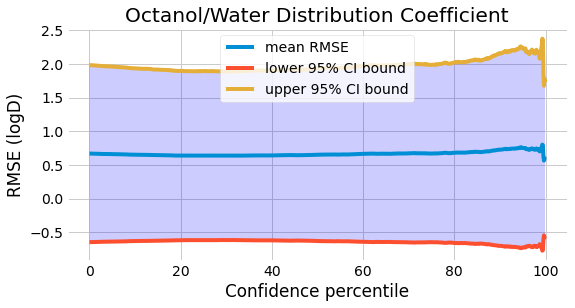

In [45]:
# set size
plt.figure(figsize=FIGSIZE_HEATMAP)

plt.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
plt.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
plt.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
plt.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

plt.legend(loc='upper center')

plt.title(datasets_to_titles[dataset])
plt.xlabel('Confidence percentile')
plt.ylabel(f'RMSE {datasets_to_units[dataset]}')

#plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_with_ci_bounds_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()

### Together

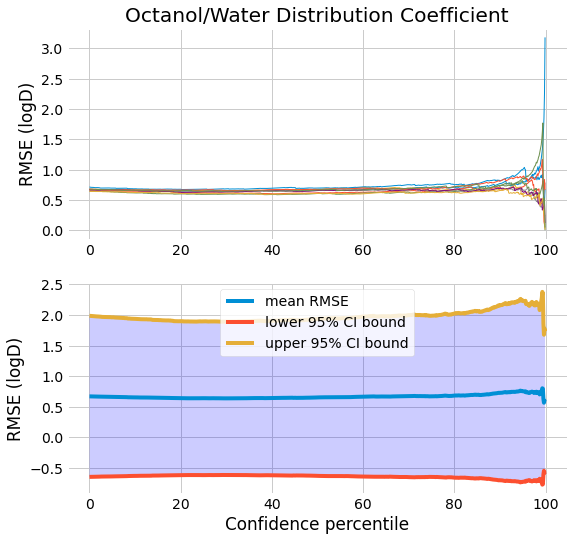

In [46]:
# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8)) #, sharey=True

for flipped_cumul_rmse in flipped_cumulrmse_mult_runs:
    ax1.plot(confidence_percentiles, flipped_cumul_rmse, linewidth=1)

ax1.set_title(datasets_to_titles[dataset])
#ax1.set_xlabel('Confidence percentile')
ax1.set_ylabel(f'RMSE {datasets_to_units[dataset]}')


ax2.plot(confidence_percentiles, flipped_cumulrmse_mean, label=f'mean {metric}')
ax2.plot(confidence_percentiles, flipped_cumulrmse_lower, label=f'lower 95% CI bound')
ax2.plot(confidence_percentiles, flipped_cumulrmse_upper, label=f'upper 95% CI bound')
ax2.fill_between(confidence_percentiles, flipped_cumulrmse_upper, flipped_cumulrmse_lower, facecolor='blue', alpha=0.2)

ax2.legend(loc='upper center')

#ax2.set_title(datasets_to_titles[dataset])
ax2.set_xlabel('Confidence percentile')
ax2.set_ylabel(f'RMSE {datasets_to_units[dataset]}')

plt.savefig(f'{PLOTS_DIR}/ci_plots/cumulrmse_vs_confidence_multiple_runs_both_{dataset}_{cf}_{model}.png', dpi=DPI, bbox_inches='tight')
plt.show()